# MySQL AI
MySQL AI provides developers to build rich applications with MySQL leveraging built in machine learning, GenAI, LLMs and semantic search. They can create vectors from documents stored in a local file system. Customers can deploy these AI applications on premise or migrate them to MySQL HeatWave for lower cost, higher performance, richer functionality and latest LLMs with no change to their application. This gives developers the flexibility to build their applications on MySQL EE and then deploy them either on premise or in the cloud.

### Machine Learning with Diamonds Dataset Notebook
This notebook explores the application of machine learning techniques to the Diamonds dataset is a classic dataset in the field of machine learning, often used for practicing regression and data analysis techniques. It contains information about approximately 54,000 diamonds, including their prices and various attributes.

The dataset provides a rich source of information for understanding the factors that influence diamond prices. It's a great resource for beginners learning data analysis and visualization, as well as for more advanced machine learning tasks like predictive modeling.

The dataset includes the following columns:

- price: The price of the diamond in US dollars ($326 - $18,823)
- carat: The weight of the diamond (0.2 - 5.01)
- cut: The quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color: Diamond color, from J (worst) to D (best)
- clarity: A measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))   
- x: Length in mm (0 - 10.74)
- y: Width in mm (0 - 58.9)
- z: Depth in mm (0 - 31.8)
- depth: Total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43 - 79)
- table: Width of top of diamond relative to widest point (43 - 95)

Throughout this notebook, we will use MySQL AI AutoML to predict the price of a diamond based on its characteristics and prior prices of other diamonds.

### References
- https://blogs.oracle.com/mysql/post/announcing-mysql-ai
- https://dev.mysql.com/doc/mysql-ai/9.4/en/
- https://dev.mysql.com/doc/dev/mysql-studio/latest/#overview

### Prerequistises

- mysql-connector-python
- pandas 
- seaborn 
- sshtunnel 
- scikit-learn
- sqlalchemy
- matplotlib

In [7]:
import os
import json
import numpy as np
import pandas as pd
import sqlalchemy
import mysql.connector
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Connect to MySQL AI instance
We create a connection to an active MySQL AI instance using the [MySQL Connector/Python](https://dev.mysql.com/doc/connector-python/en/). We also define an API to execute a SQL query using a cursor, and the result is returned as a Pandas DataFrame. Modify the below variables to point to your MySQL AI instance.

 - In MySQL Studio, connections are restricted to only allow localhost as the host. 
 - In MySQL Studio, the only accepted password values are the string unused or None. 

In [ ]:
HOST = 'localhost'
PORT = 3306
USER = 'root'
PASSWORD = 'unused'
SCHEMA = 'mlcorpus'


myconn = mysql.connector.connect(
    host=HOST,
    port=PORT,
    user=USER,
    password=PASSWORD,
    database=SCHEMA,
    allow_local_infile=True,
    use_pure=True,
    autocommit=True,
)
mycursor = myconn.cursor()

# Helper function to execute SQL queries and return the results as a Pandas DataFrame
def execute_sql(sql: str) -> pd.DataFrame:
    mycursor.execute(sql)
    return pd.DataFrame(mycursor.fetchall(), columns=mycursor.column_names)

 ### Download the Diamonds dataset and load it into Python
 Download the diamonds dataset from [OpenML](https://www.openml.org/search?type=data&status=active&id=42225) and upload it into My Files folder in MySQL AI Studio.
 
 You can use the following curl command to download the dataset:

 curl -O https://www.openml.org/data/get_csv/21792853/dataset.csv

 We load into Python using Pandas.

In [9]:
# Create a Pandas dataframe from the data
path = "/workspace/datasets/"
df = pd.read_csv(os.path.join(path, "dataset.csv"), header=0, sep=",", encoding="utf-8")

### Split the data into a training set and an evaluation set
In machine learning, the train-test split is a crucial technique used to evaluate the performance of a model on unseen data. It involves dividing the available dataset into two distinct subsets:   

- Training set: This subset is used to train the machine learning model. The model learns the underlying patterns and relationships in the data by analyzing this set.   
- Test set: This subset is held back and not used during the training process. Once the model is trained, it's applied to the test set to assess its ability to generalize to new, unseen data.

In [10]:
df_train, df_test = train_test_split(
    df, test_size=0.30, random_state=1
)
df_train = df_train.replace({np.nan: "NULL"})
df_test = df_test.replace({np.nan: "NULL"})

 ### Load the Diamonds dataset into MySQL tables
 We connect to the MySQL AI instance using SQLAlchemy, map Pandas data types to their corresponding MySQL dialects, and writes two DataFrames (df_train and df_test) to separate tables (diamonds_train and diamonds_test) in the MySQL, replacing any existing tables.

In [11]:
# Create a SQLAlchemy engine instance to connect to the MySQL database
sql_engine = sqlalchemy.create_engine(
    f"mysql+mysqlconnector://{USER}:{PASSWORD}@{HOST}:{PORT}/{SCHEMA}",
    echo=False,
    echo_pool=False,
    pool_pre_ping=True,
    pool_recycle=3600,
)

# Define a dictionary mapping pandas data types to their corresponding SQLAlchemy dialects
dtype_mapping = {
    "uint64": sqlalchemy.dialects.mysql.INTEGER(unsigned=True),
    "int64": sqlalchemy.dialects.mysql.INTEGER(),
    "float64": sqlalchemy.dialects.mysql.FLOAT(),
    "object": sqlalchemy.dialects.mysql.VARCHAR(length=255),
    "datetime64[ns]": sqlalchemy.dialects.mysql.DATETIME(timezone=False),
    "bool": sqlalchemy.dialects.mysql.TINYINT(),
}
# Prepare the dtype dict for sqlalchemy/pd.DataFrame.to_sql
dtypes = {col: dtype_mapping[str(dtype)] for col, dtype in zip(df.columns, df.dtypes)}

# Write the training DataFrame to the 'diamonds_train' table in the database
df_train.to_sql(
    f"diamonds_train",
    con=sql_engine,
    if_exists="replace",
    dtype=dtypes,
    chunksize=5000,
    index=False,
)
# Write the testing DataFrame to the 'diamonds_test' table in the database
df_test.to_sql(
    f"diamonds_test",
    con=sql_engine,
    if_exists="replace",
    dtype=dtypes,
    chunksize=5000,
    index=False,
)

-4

### Create a AutoML model from the Diamonds training dataset
We create a machine learning model on the diamonds dataset using the [ML_TRAIN](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-ml-train.html) API. The column price in the data contains what the price of the diamond is. We specify price as the column that we are trying to learn on, since we need to predict for a new diamond what its price will be. The model handle generated at the end of training is stored in the model variable. We will use this handle to refer to the model in our future interactions

In [13]:
execute_sql("""SET @model = NULL;""")
execute_sql(
    f"""CALL sys.ML_TRAIN('{SCHEMA}.diamonds_train', 'price', JSON_OBJECT('task', 'regression'), @model)"""
)
model = execute_sql("""SELECT @model;""").iat[0,0]
execute_sql(f"""CALL sys.ML_MODEL_LOAD('{model}', NULL)""")

""


### Evaluate the model
We look at the overall performance of the model on unseen data by using the [ML_SCORE](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-ml-score.html) routine to compute the average error in price across predictions. The error metric tells us on average how much the prediction of the model will vary from the actual price on the diamonds_test data.

In [14]:
execute_sql(
    f"""CALL sys.ML_SCORE('{SCHEMA}.diamonds_test', 'price', '{model}', 'neg_mean_absolute_error', @score, NULL);"""
)
score = execute_sql("""SELECT @score;""").iat[0,0]
print(f"The model error is {-score:.2f}")

The model error is 271.23


### Generating predictions to evaluate model performance on unseen test data
We invoke the [ML_PREDICT_TABLE](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-ml-predict-table.html) API to generate prediction for the above model on our test data. The output table contains 2 extra columns 
- Prediction: Contains the actual prediction from the model. This is what the model thinks the customer will do based on the data it has learned from earlier.
- ml_results: This contains more details about the prediction

In [15]:
execute_sql(f"""DROP TABLE IF EXISTS diamonds_test_predictions""")
execute_sql(
    f"""CALL sys.ML_PREDICT_TABLE('{SCHEMA}.diamonds_test', '{model}', '{SCHEMA}.diamonds_test_predictions', NULL)"""
)
df_predictions = execute_sql(f"""SELECT * FROM diamonds_test_predictions""")
execute_sql(f"""DROP TABLE IF EXISTS diamonds_test_predictions""")
df_predictions.head()

,_4aad19ca6e_pk_id,carat,cut,color,clarity,depth,table,price,x,y,z,Prediction,ml_results
0,1,0.33,Ideal,H,SI1,61.7,55.0,564,4.43,4.46,2.74,533.688,"{""predictions"": {""price"": 533.6876689767317}}"
1,2,1.20,Ideal,I,VS2,62.1,57.0,5914,6.78,6.71,4.19,5526.220,"{""predictions"": {""price"": 5526.215616919986}}"
2,3,0.62,Ideal,D,VS1,61.0,57.0,2562,5.51,5.54,3.37,2529.560,"{""predictions"": {""price"": 2529.5590478500144}}"
3,4,0.34,Good,H,VS2,63.1,56.0,537,4.41,4.46,2.80,551.051,"{""predictions"": {""price"": 551.0509373731402}}"
4,5,1.20,Ideal,E,SI2,62.5,55.0,5964,6.77,6.84,4.25,5968.800,"{""predictions"": {""price"": 5968.798837177928}}"


### Getting a deeper understanding of the model's predictions

Regression models predict on continous values, so we would like to understand how close the model was to predicting the actual price. We use a regression plot, where the X axis shows the actual price of a diamond, and the y axis shows the predicted price for the same diamond. So the closer each point is to the X=Y line across the center, the more accurate the model is. 

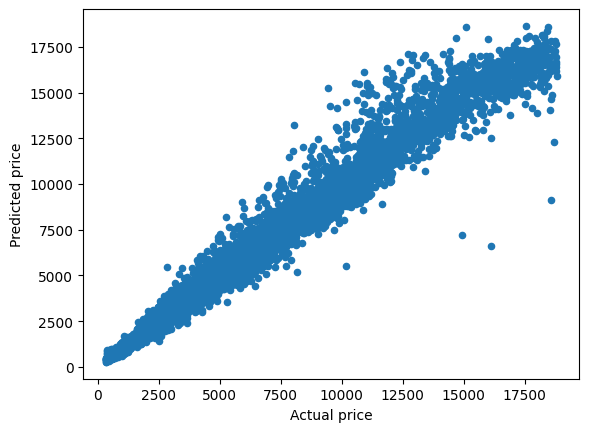

In [16]:
df = pd.DataFrame()
df['Predicted price'] = df_predictions['Prediction']
df['Actual price'] = df_predictions['price'].astype(float)
df.plot.scatter(x='Actual price', y='Predicted price')
plt.show()

### Model explanations

MySQL AI AutoML also provides [model explanations](https://dev.mysql.com/doc/heatwave/en/mys-hwaml-model-viewing.html) which provide a global view of which columns contributed the most to create the model. Interesting the carat and the width of the diamond (y) seem to be the most important factors in deciding the price.

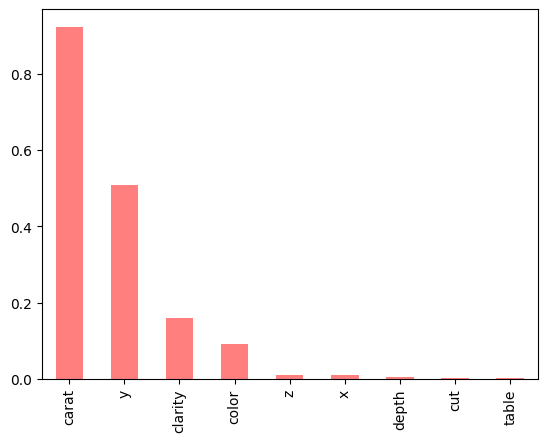

In [17]:
df = execute_sql(
    f"""SELECT model_explanation FROM ML_SCHEMA_{USER}.MODEL_CATALOG WHERE model_handle = '{model}'"""
)
pd.Series(json.loads(df.iat[0,0])["permutation_importance"]).sort_values(
    axis=0, ascending=False
).plot(kind="bar", color="r", alpha=0.5)
plt.show()

We invite you to try [HeatWave AutoML and GenAI](https://www.oracle.com/heatwave/free/). If you’re new to Oracle Cloud Infrastructure, try Oracle Cloud Free Trial, a free 30-day trial with US$300 in credits.